In [15]:
!pip install torchtoolbox

In [16]:
import math
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.nn import Module, ModuleList, Linear, Dropout, LayerNorm, Identity, Parameter, init
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder, CIFAR100
import random
from PIL import Image, ImageEnhance, ImageOps



In [17]:
!pip install opendatasets
import opendatasets as od


od.download('https://www.kaggle.com/c/2021-ai-training-final-project/data')
data_dir = './2021-ai-training-final-project/CIFAR100'

Skipping, found downloaded files in "./2021-ai-training-final-project" (use force=True to force download)


In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_default_device()
print(device)
!nvidia-smi

cuda
Sun Sep  5 07:34:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [19]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:

class CCT(nn.Module):
    def __init__(self,
                 img_size=224,
                 embedding_dim=768,
                 n_input_channels=3,
                 n_conv_layers=1,
                 kernel_size=7,
                 stride=2,
                 padding=3,
                 pooling_kernel_size=3,
                 pooling_stride=2,
                 pooling_padding=1,
                 *args, **kwargs):
        super(CCT, self).__init__()

        self.tokenizer = Tokenizer(n_input_channels=n_input_channels,
                                   n_output_channels=embedding_dim,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   pooling_kernel_size=pooling_kernel_size,
                                   pooling_stride=pooling_stride,
                                   pooling_padding=pooling_padding,
                                   max_pool=True,
                                   activation=nn.ReLU,
                                   n_conv_layers=n_conv_layers,
                                   conv_bias=False)

        self.classifier = TransformerClassifier(
            sequence_length=self.tokenizer.sequence_length(n_channels=n_input_channels,
                                                           height=img_size,
                                                           width=img_size),
            embedding_dim=embedding_dim,
            seq_pool=True,
            dropout_rate=0.,
            attention_dropout=0.1,
            stochastic_depth=0.1,
            *args, **kwargs)

    def forward(self, x):
        x = self.tokenizer(x)
        return self.classifier(x)




def _cct(num_layers, num_heads, mlp_ratio, embedding_dim,
         kernel_size=3, stride=None, padding=None,
         *args, **kwargs):
    stride = stride if stride is not None else max(1, (kernel_size // 2) - 1)
    padding = padding if padding is not None else max(1, (kernel_size // 2))
    return CCT(num_layers=num_layers,
               num_heads=num_heads,
               mlp_ratio=mlp_ratio,
               embedding_dim=embedding_dim,
               kernel_size=kernel_size,
               stride=stride,
               padding=padding,
               *args, **kwargs)



def cct_6(*args, **kwargs):
    return _cct(num_layers=6, num_heads=4, mlp_ratio=2, embedding_dim=256,
                *args, **kwargs)





In [21]:

class Tokenizer(nn.Module):
    def __init__(self,
                 kernel_size, stride, padding,
                 pooling_kernel_size=3, pooling_stride=2, pooling_padding=1,
                 n_conv_layers=1,
                 n_input_channels=3,
                 n_output_channels=64,
                 in_planes=64,
                 activation=None,
                 max_pool=True,
                 conv_bias=False):
        super(Tokenizer, self).__init__()

        n_filter_list = [n_input_channels] + \
                        [in_planes for _ in range(n_conv_layers - 1)] + \
                        [n_output_channels]

        self.conv_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(n_filter_list[i], n_filter_list[i + 1],
                          kernel_size=(kernel_size, kernel_size),
                          stride=(stride, stride),
                          padding=(padding, padding), bias=conv_bias),
                nn.Identity() if activation is None else activation(),
                nn.MaxPool2d(kernel_size=pooling_kernel_size,
                             stride=pooling_stride,
                             padding=pooling_padding) if max_pool else nn.Identity()
            )
                for i in range(n_conv_layers)
            ])

        self.flattener = nn.Flatten(2, 3)
        self.apply(self.init_weight)

    def sequence_length(self, n_channels=3, height=224, width=224):
        return self.forward(torch.zeros((1, n_channels, height, width))).shape[1]

    def forward(self, x):
        return self.flattener(self.conv_layers(x)).transpose(-2, -1)

    @staticmethod
    def init_weight(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)



In [22]:

class Attention(Module):
    def __init__(self, dim, num_heads=8, attention_dropout=0.1, projection_dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // self.num_heads
        self.scale = head_dim ** -0.5

        self.qkv = Linear(dim, dim * 3, bias=False)
        self.attn_drop = Dropout(attention_dropout)
        self.proj = Linear(dim, dim)
        self.proj_drop = Dropout(projection_dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x




class TransformerEncoderLayer(Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 attention_dropout=0.1, drop_path_rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.pre_norm = LayerNorm(d_model)
        self.self_attn = Attention(dim=d_model, num_heads=nhead,
                                   attention_dropout=attention_dropout, projection_dropout=dropout)

        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout1 = Dropout(dropout)
        self.norm1 = LayerNorm(d_model)
        self.linear2 = Linear(dim_feedforward, d_model)
        self.dropout2 = Dropout(dropout)

        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0 else Identity()

        self.activation = F.gelu

    def forward(self, src: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        src = src + self.drop_path(self.self_attn(self.pre_norm(src)))
        src = self.norm1(src)
        src2 = self.linear2(self.dropout1(self.activation(self.linear1(src))))
        src = src + self.drop_path(self.dropout2(src2))
        return src




class TransformerClassifier(Module):
    def __init__(self,
                 seq_pool=True,
                 embedding_dim=768,
                 num_layers=12,
                 num_heads=12,
                 mlp_ratio=4.0,
                 num_classes=1000,
                 dropout_rate=0.1,
                 attention_dropout=0.1,
                 stochastic_depth_rate=0.1,
                 positional_embedding='sine',
                 sequence_length=None,
                 *args, **kwargs):
        super().__init__()
        positional_embedding = positional_embedding if \
            positional_embedding in ['sine', 'learnable', 'none'] else 'sine'
        dim_feedforward = int(embedding_dim * mlp_ratio)
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.seq_pool = seq_pool

        assert sequence_length is not None or positional_embedding == 'none', \
            f"Positional embedding is set to {positional_embedding} and" \
            f" the sequence length was not specified."

        if not seq_pool:
            sequence_length += 1
            self.class_emb = Parameter(torch.zeros(1, 1, self.embedding_dim),
                                       requires_grad=True)
        else:
            self.attention_pool = Linear(self.embedding_dim, 1)

        if positional_embedding != 'none':
            if positional_embedding == 'learnable':
                self.positional_emb = Parameter(torch.zeros(1, sequence_length, embedding_dim),
                                                requires_grad=True)
                init.trunc_normal_(self.positional_emb, std=0.2)
            else:
                self.positional_emb = Parameter(self.sinusoidal_embedding(sequence_length, embedding_dim),
                                                requires_grad=False)
        else:
            self.positional_emb = None

        self.dropout = Dropout(p=dropout_rate)
        dpr = [x.item() for x in torch.linspace(0, stochastic_depth_rate, num_layers)]
        self.blocks = ModuleList([
            TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads,
                                    dim_feedforward=dim_feedforward, dropout=dropout_rate,
                                    attention_dropout=attention_dropout, drop_path_rate=dpr[i])
            for i in range(num_layers)])
        self.norm = LayerNorm(embedding_dim)

        self.fc = Linear(embedding_dim, num_classes)
        self.apply(self.init_weight)

    def forward(self, x):
        if self.positional_emb is None and x.size(1) < self.sequence_length:
            x = F.pad(x, (0, 0, 0, self.n_channels - x.size(1)), mode='constant', value=0)

        if not self.seq_pool:
            cls_token = self.class_emb.expand(x.shape[0], -1, -1)
            x = torch.cat((cls_token, x), dim=1)

        if self.positional_emb is not None:
            x += self.positional_emb

        x = self.dropout(x)

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        if self.seq_pool:
            x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)
        else:
            x = x[:, 0]

        x = self.fc(x)
        return x

    @staticmethod
    def init_weight(m):
        if isinstance(m, Linear):
            init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, Linear) and m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, LayerNorm):
            init.constant_(m.bias, 0)
            init.constant_(m.weight, 1.0)

    @staticmethod
    def sinusoidal_embedding(n_channels, dim):
        pe = torch.FloatTensor([[p / (10000 ** (2 * (i // 2) / dim)) for i in range(dim)]
                                for p in range(n_channels)])
        pe[:, 0::2] = torch.sin(pe[:, 0::2])
        pe[:, 1::2] = torch.cos(pe[:, 1::2])
        return pe.unsqueeze(0)



In [23]:

class ShearX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude)
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)

In [24]:

class CIFAR10Policy(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearX": ShearX(fillcolor=fillcolor),
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img

In [25]:

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

In [26]:
def adjust_learning_rate(optimizer, epoch):
    lrr = lr
    if epoch < warmup:
        lrr = lr / (warmup - epoch)
    else:
        lrr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup) / (total_epochs - warmup)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lrr


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']



def accuracy(output, target):
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(1, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        correct_k = correct[:1].flatten().float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
        return res


def train(loss_train_arr, train_loader, model, criterion, optimizer, epoch):
    model.train()
    loss_val, acc1_val = 0, 0
    n = 0
    for i, (images, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = images.cuda(gpu_id, non_blocking=True)
            target = target.cuda(gpu_id, non_blocking=True)
        output = model(images)

        loss = criterion(output, target)

        acc1 = accuracy(output, target)
        n += images.size(0)
        loss_val += float(loss.item() * images.size(0))
        acc1_val += float(acc1[0] * images.size(0))

        optimizer.zero_grad()
        loss.backward()

        if clip_grad_norm > 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm, norm_type=2)

        optimizer.step()

        
    avg_loss, avg_acc1 = (loss_val / n), (acc1_val / n)

    print(f'Train: Epoch [{epoch + 1}], Loss: {avg_loss:.4e}, acc: {avg_acc1:6.2f}')
    
    loss_train_arr.append(avg_loss)
    
    return loss_train_arr


def validate(loss_val_arr, val_loader, model, criterion,  epoch=None):
    model.eval()
    loss_val, acc1_val = 0, 0
    n = 0
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            if torch.cuda.is_available():
                images = images.cuda(gpu_id, non_blocking=True)
                target = target.cuda(gpu_id, non_blocking=True)

            output = model(images)
            loss = criterion(output, target)

            acc1 = accuracy(output, target)
            n += images.size(0)
            loss_val += float(loss.item() * images.size(0))
            acc1_val += float(acc1[0] * images.size(0))


    avg_loss, avg_acc1 = (loss_val / n), (acc1_val / n)
   
    print(f'Eval: Epoch [{epoch + 1}], Loss: {avg_loss:.4e},  acc: {avg_acc1:6.2f} ')

    loss_val_arr.append(avg_loss)

    return loss_val_arr, avg_acc1



class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1. - smoothing

    def _compute_losses(self, x, target):
        log_prob = F.log_softmax(x, dim=-1)
        nll_loss = -log_prob.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_prob.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss

    def forward(self, x, target):
        return self._compute_losses(x, target).mean()

In [27]:
def test(model,data_loader,valid_ds):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        correct = 0
        bs = batch_size
        result = []
        check_names = []
        for i, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            arr = pred.data.cpu().numpy()
            for j in range(pred.size()[0]):
                file_name = valid_ds.samples[i*bs+j][0].split('/')[-1]
                result.append((file_name,pred[j].cpu().numpy()[0])) 
        
    return result

In [28]:

workers=2
pretrain_path='cct6-3x1_cifar100_epoch200_training.pth'
checkpoint_path = 'cct6-3x1_cifar100_test.pth'

# L/PxC 
# L = transformer layers
# P = patch/convolution size
# C = convolutional layers


total_epochs=200
start_epoch=0
end_epoch=2

warmup=20
batch_size=128
lr=0.0005
weight_decay=3e-2
clip_grad_norm=0.
model='cct_6'
positional_embedding='learnable'
conv_layers=1
conv_size=3
patch_size=4
gpu_id=0




#cifar100
num_classes = 100
img_size = 32
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]
    

model = cct_6(img_size=img_size,
              num_classes=num_classes,
              positional_embedding=positional_embedding,
              n_conv_layers=conv_layers,
              kernel_size=conv_size,
              patch_size=patch_size).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [29]:
best_acc1=0
loss_train_arr =[]
loss_val_arr =[]
lrs =[]



model.load_state_dict(torch.load(pretrain_path, map_location='cpu'))


criterion = LabelSmoothingCrossEntropy()

if torch.cuda.is_available():
    torch.cuda.set_device(gpu_id)
    criterion = criterion.cuda(gpu_id)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr,
                                weight_decay=weight_decay)


In [30]:
normalize = [transforms.Normalize(mean=mean, std=std)]

augmentations = transforms.Compose([
    transforms.RandomCrop(img_size, padding=4),
    transforms.RandomHorizontalFlip(),
    CIFAR10Policy(),
    transforms.ToTensor(),
    *normalize,
])

train_dataset = ImageFolder(
    root=data_dir+"/TRAIN",   transform=augmentations)

val_dataset = ImageFolder(
    root=data_dir+"/TEST",   transform=transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        *normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=workers)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=False,
    num_workers=workers)


train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)


In [31]:
for epoch in range(start_epoch, end_epoch):
    adjust_learning_rate(optimizer, epoch)
    loss_train_arr = train(loss_train_arr, train_loader, model, criterion, optimizer, epoch)
    loss_val_arr, acc1 = validate(loss_val_arr, val_loader, model, criterion,  epoch=epoch)
    best_acc1 = max(acc1, best_acc1)
    lrs.append(get_lr(optimizer))
    print(f'lr: {lrs[-1]:.4e}')



torch.save(model.state_dict(), checkpoint_path)

result = test(model, val_loader, val_dataset)

with open ('ID_result.csv','w') as f:
    f.write('Id,Category\n')
    for data in result:
        f.write(data[0]+','+str(data[1])+'\n')


Train: Epoch [1], Loss: 1.0637e+00, acc:  93.18
Eval: Epoch [1], Loss: 1.6225e+00,  acc:  75.37 
lr: 2.5000e-05
Train: Epoch [2], Loss: 1.0664e+00, acc:  93.13
Eval: Epoch [2], Loss: 1.6242e+00,  acc:  75.07 
lr: 2.6316e-05


In [32]:

from torchsummary import summary

# Print parameter
size = summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 32, 32]           6,912
              ReLU-2          [-1, 256, 32, 32]               0
         MaxPool2d-3          [-1, 256, 16, 16]               0
           Flatten-4             [-1, 256, 256]               0
         Tokenizer-5             [-1, 256, 256]               0
           Dropout-6             [-1, 256, 256]               0
         LayerNorm-7             [-1, 256, 256]             512
            Linear-8             [-1, 256, 768]         196,608
           Dropout-9          [-1, 4, 256, 256]               0
           Linear-10             [-1, 256, 256]          65,792
          Dropout-11             [-1, 256, 256]               0
        Attention-12             [-1, 256, 256]               0
         Identity-13             [-1, 256, 256]               0
        LayerNorm-14             [-1, 2

[1.0637174175834656, 1.0664437671470641]
[1.6224999289961906, 1.6242396833897115]


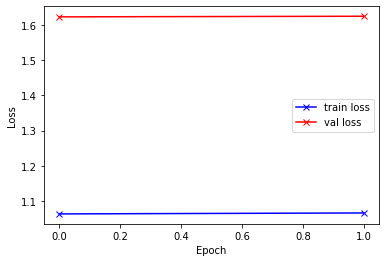

In [33]:

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


plt.plot([x for x in loss_train_arr], "-bx")
plt.plot([x for x in loss_val_arr],"-rx")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train loss","val loss"])

print(loss_train_arr)
print(loss_val_arr)


[2.5e-05, 2.6315789473684212e-05]


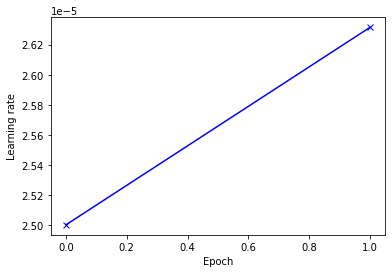

In [34]:
plt.plot([x for x in lrs], "-bx")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")

print(lrs)